### Gloden cross strategy

In [82]:
import time
from datetime import datetime

import pandas as pd
import pandas_ta as ta
import numpy as np
import mplfinance as mpf

### import csv

In [83]:
data = pd.read_csv('USDJPY_15m_2022_01_03.csv')
data.tail()

,timestamp,open,high,low,close,adj close,volumn
3887,2021-12-31 20:45:00+00:00,115.051003,115.110001,115.010002,115.095001,115.095001,0
3888,2021-12-31 21:00:00+00:00,115.091003,115.095001,115.029999,115.056999,115.056999,0
3889,2021-12-31 21:15:00+00:00,115.056999,115.073997,115.019997,115.061996,115.061996,0
3890,2021-12-31 21:30:00+00:00,115.061996,115.087997,115.040001,115.070000,115.070000,0
3891,2021-12-31 21:45:00+00:00,115.080002,115.116997,115.050003,115.102997,115.102997,0


In [84]:
df = data.copy()

### Create strategy

In [4]:
gloden_cross = ta.Strategy(
    name = 'Gloden cross',
    description = 'Gloden cross by EMA 2 Line',
    ta = [
        {'kind': 'ema', 'length': 200},
        {'kind': 'ema', 'length': 10},
        {'kind': 'ema', 'length': 50}
    ]
)
df.ta.strategy(gloden_cross)

### Create signal

In [87]:
class BacktestGlodenCross:
    def __init__(self, params):
        self.orders = pd.DataFrame(columns = ['action', 'open time', 'open', 'close time', 'close', 'T/P', 'S/L', 'result'])
        self.order = {'action': None, 'open time': None, 'open': None, 'close time': None, \
                      'close': None, 'T/P': None, 'S/L': None,'result': None}
        self.unknow_result = []
        
        self.current_action = 'close'
        self.atr_len = params['atr_len']
        self.ema_1 = params['ema_1']
        self.ema_2 = params['ema_2']
        
        self.pip_value = params['pip_value']
        self.rr = params['rr']
        self.df = params['df']
        
    def reset_order(self):
        self.order = {'action': None, 'open time': None, 'open': None, 'close time': None, \
                      'close': None, 'T/P': None, 'S/L': None,'result': None}
        
    def plot_order(self, order):
        df = self.df.copy()
        df.set_index('timestamp', inplace = True)
        data_plot = df.loc[order['open time']:order['close time']]
        mpf.plot(data_plot, type='candle', style='charles', figsize=(8, 4))
        
    def backtest(self):
        n_bars = 3
        gloden_cross = ta.Strategy(
            name = 'Gloden cross',
            description = 'Gloden cross by EMA 2 Line',
            ta = [
                {'kind': 'ema', 'length': 200},
                {'kind': 'ema', 'length': self.ema_1},
                {'kind': 'ema', 'length': self.ema_2},
                {'kind': 'atr', 'length': self.atr_len}
            ]
        )
        self.df.ta.strategy(gloden_cross)
        self.df.dropna()
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        
        for index, row in self.df.iterrows():
            entry = 0
            
            if self.current_action == 'close':
            
                if (row['EMA_'+str(self.ema_1)] > row['EMA_'+str(self.ema_2)]) and (row['low'] > row['EMA_'+str(200)]):
                    # check if previous n bars ema_1 < ema_2 then buy.
                    if index > n_bars:
                        for pre_index, pre_row in self.df.iloc[index-n_bars:index].iterrows():
                            if (pre_row['EMA_'+str(self.ema_1)] < pre_row['EMA_'+str(self.ema_2)]):
                                row['action'] = 'buy'
                                self.order['action'] = 'buy'
                                self.order['open time'] = row['timestamp']
                                self.order['open'] = row['open']
                                self.order['S/L'] = row['open'] - row['ATRr_'+str(self.atr_len)]
                                self.order['T/P'] = row['open'] + (self.rr * abs(row['open'] - self.order['S/L']))
                                self.current_action = 'buy'
                        
                elif (row['EMA_'+str(self.ema_1)] < row['EMA_'+str(self.ema_2)]) and (row['high'] < row['EMA_'+str(200)]):
                    # check if previous n bars ema_1 > ema_2 then sell.
                    if index > n_bars:
                        for pre_index, pre_row in self.df.iloc[index-n_bars:index].iterrows():
                            if (pre_row['EMA_'+str(self.ema_1)] > pre_row['EMA_'+str(self.ema_2)]):
                                row['action'] = 'sell'
                                self.order['action'] = 'sell'
                                self.order['open time'] = row['timestamp']
                                self.order['open'] = row['open']
                                self.order['S/L'] = row['open'] + row['ATRr_'+str(self.atr_len)]
                                self.order['T/P'] = row['open'] - (self.rr * abs(row['open'] - self.order['S/L']))
                                self.current_action = 'sell'
        
            if self.current_action == 'buy':
                if row['low'] <= self.order['S/L'] and row['high'] >= self.order['T/P']:
                    self.unknow_result.append(row)
                    
                if row['low'] <= self.order['S/L']:
                    self.order['result'] = 'S/L'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['S/L']
                    
                    self.current_action = 'close'
                    self.orders = self.orders.append(self.order, ignore_index = True)
                    self.reset_order()
                    
                elif row['high'] >= self.order['T/P']:
                    self.order['result'] = 'T/P'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['T/P']
                    
                    self.current_action = 'close'
                    self.orders = self.orders.append(self.order, ignore_index = True)
                    self.plot_order(self.order)
                    self.reset_order()

            elif self.current_action == 'sell':
                if row['high'] >= self.order['S/L'] and row['low'] <= self.order['T/P']:
                    self.unknow_result.append(row)
                    
                if row['high'] >= self.order['S/L']:
                    self.order['result'] = 'S/L'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['S/L']
                    
                    self.current_action = 'close'
                    self.orders = self.orders.append(self.order, ignore_index = True)
                    self.reset_order()
                    
                elif row['low'] <= self.order['T/P']:
                    self.order['result'] = 'T/P'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['T/P']
                    
                    self.current_action = 'close'
                    self.orders = self.orders.append(self.order, ignore_index = True)
                    self.reset_order()

        try:
            win_rate = round(len(self.orders[self.orders['result'] == 'T/P']) * 100 / len(self.orders), 2)
            loss_rate = round(len(self.orders[self.orders['result'] == 'S/L']) * 100 / len(self.orders), 2)

            win_orders = int((win_rate * len(self.orders)) / 100 )
            loss_orders = len(self.orders) - win_orders
            gain = (win_orders * self.rr) - loss_orders

            result_info = f"total orders: {len(self.orders)}\nema_1: {self.ema_1}, ema_2: {self.ema_2}, atr: {self.atr_len}, gain: {gain}\n"
            return {'win_rate': win_rate, 'info': result_info, 'total_order': len(self.orders), 'rr': self.rr, 'gain': gain, 'unknow': self.unknow_result}
        except:
    #         print("No orders to action")
            return {'win_rate': 0, 'info': 'No orders to action'}

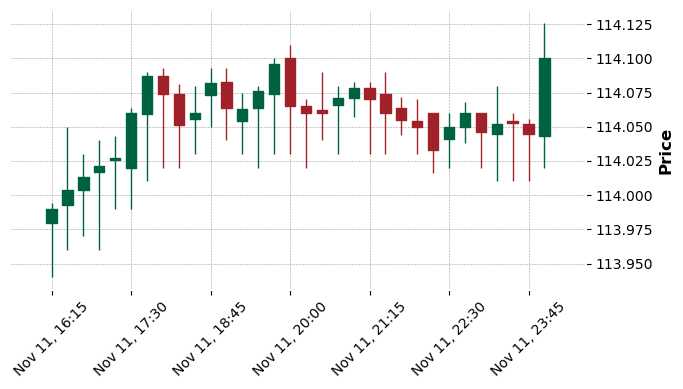

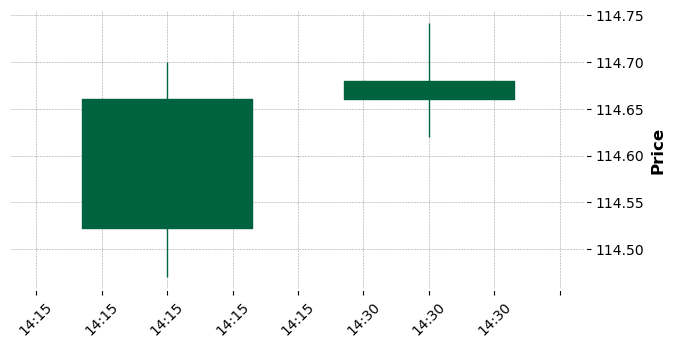

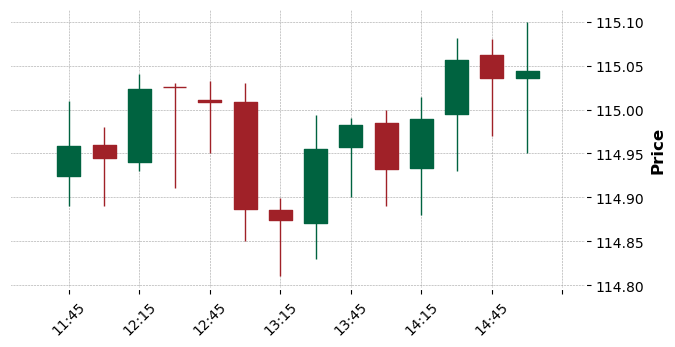

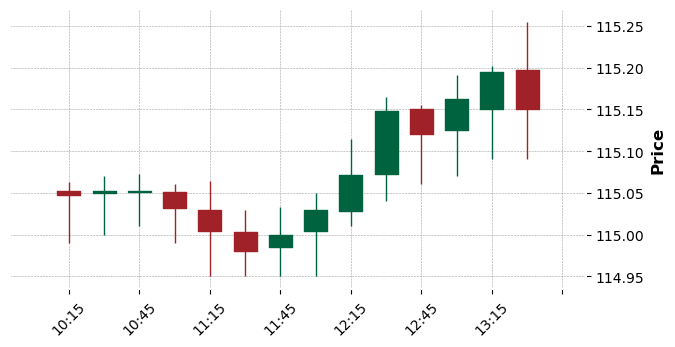

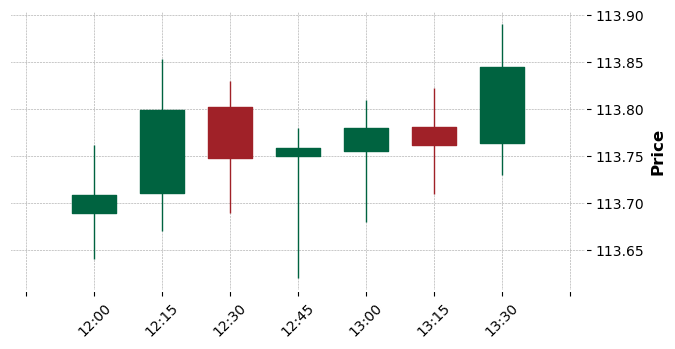

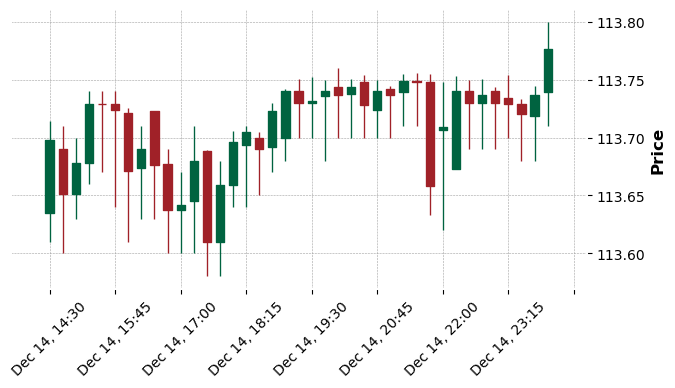

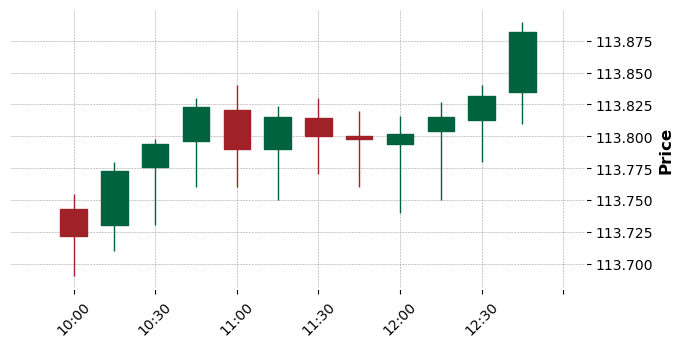

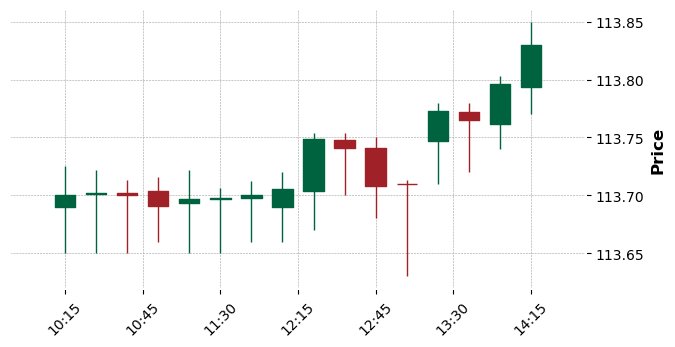

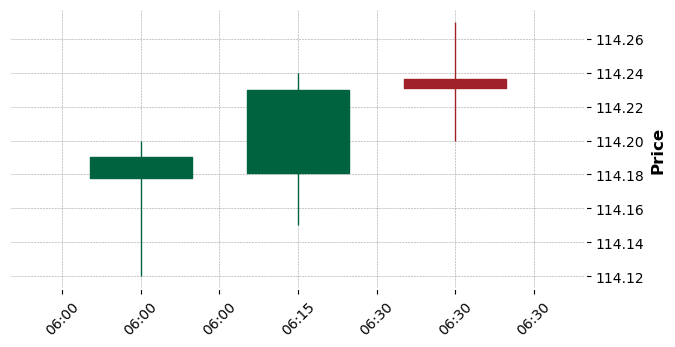

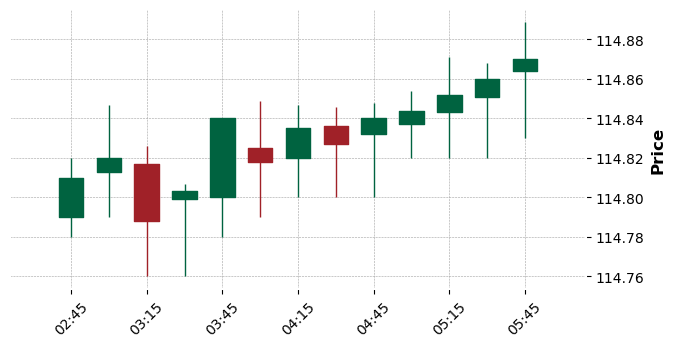

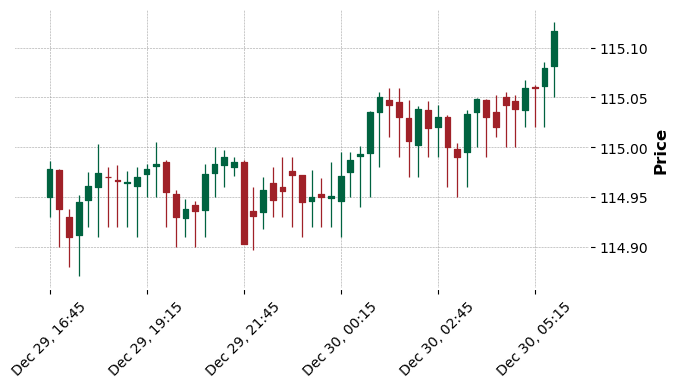

{'win_rate': 44.64,
 'info': 'total orders: 56\nema_1: 10, ema_2: 50, atr: 14, gain: 4.0\n',
 'total_order': 56,
 'rr': 1.5,
 'gain': 4.0,
 'unknow': []}

In [88]:
eurusd = BacktestGlodenCross({
    'atr_len': 14,
    'ema_1': 10,
    'ema_2': 50,
    'pip_value': 0.001,
    'rr': 1.5,
    'df': df
})
eurusd.backtest()

In [21]:
"""
Grid parameter example
line 1: 10 -> 40
line 2: 30 -> 80
condition line 1 < line 2 < line 3
"""
def create_grid_params(line1_start, line1_end, line2_start, line2_end):
    params = []
    for i in range(line1_start, line1_end+1):
        for j in range(line2_start, line2_end+1):
            if( i < j ):
                params.append([i, j])
    return params
params_list = create_grid_params(10, 40, 30, 80)
len(params_list)

1515

In [22]:
good_params = {'win': 0, 'info': ''}
start = 0
end = 1515
win_start = 0

loop_num = start
for param in params_list[start:end]:
    obj = BacktestGlodenCross({'atr_len': 14, 'ema_1': param[0], 'ema_2': param[1], 'pip_value': 0.001, 'rr': 1.5, 'df': df})
    result = obj.backtest()
    if result['win_rate'] > win_start and result['total_order'] > 30:
        win_start = result['win_rate']
        good_params['win'] = result['win_rate']
        good_params['info'] = result['info']
    loop_num = loop_num + 1
    print(f"run: {loop_num} to {end}", end = "\r")
    
print(f"\nwin rate: {good_params['win']} %\n{good_params['info']}")

run: 1515 to 1515
win rate: 69.7 %
total orders: 33
ema_1: 20, ema_2: 76, atr: 14, gain: 24.5



#### eurusd
* win rate: 65.22 %
* total orders: 46
* ema_1: 25, ema_2: 80, atr: 14, gain: 29.0

#### gbpusd
* win rate: 66.67 %
* total orders: 48
* ema_1: 22, ema_2: 73, atr: 14, gain: 32.0

#### audusd
* win rate: 71.64 %
* total orders: 67
* ema_1: 17, ema_2: 31, atr: 14, gain: 50.5

#### usdjpy
* win rate: 69.7 %
* total orders: 33
* ema_1: 20, ema_2: 76, atr: 14, gain: 24.5

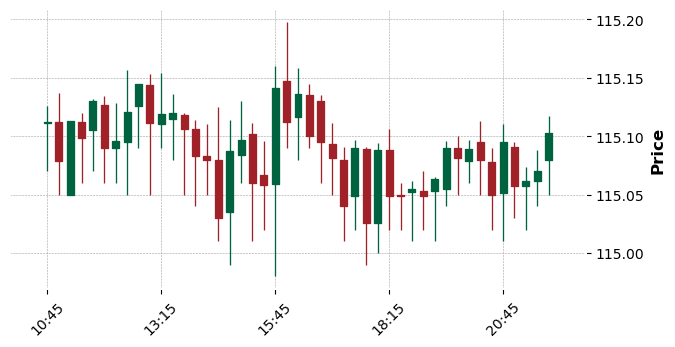

In [67]:
data_test = data.copy()
new_timestamp = data_test['timestamp'].str.split('+', n = 1, expand = True)
data_test['timestamp'] = new_timestamp[0]
data_test['timestamp'] = pd.to_datetime(data_test['timestamp'])
data_test.set_index('timestamp', inplace = True)

mpf.plot(data_test.loc['2021-12-31 10:45:00': '2021-12-31 21:45:00'], type='candle', style='charles', figsize=(8, 4))